# COGS 108 - Final Project 

# Overview

Outside of school, parks and recreation centers are where kids get the most physical activity. The relationship between poverty and conditions like diabetes and obesity are well-studied, so I wanted to see if there was a relationship between poverty and low-income with lack of park infrastructure. I was interested in exploring the effects of socioeconomic inequality on the distribution of parks and recreational facilities across the county. To do that, I grouped ZIP codes and classified them as low, middle, or high income areas depending on the percentage of people earning incomes of below $45,000, between $45,001-100,000, and above $100,000. After comparing this visualization with a map of all the parks in San Diego County, I found that there’s no significant difference between the wealthiness of a ZIP code and the number of parks it has and that there’s also no significant differences in ratings between all three classifications of ZIP Codes.

# Name & GitHub

- Name: Qiaoxuan (Josh) Wang
- GitHub Username: QXJW

# Research Question

Do we notice any significant differences between the number of parks in areas of high income (>\\$100,000 annual income), middle income (\\$45,001 - \\$99,999 annual income), and low income (<\\$45,000 annual income) levels? Are there any significant differences in Yelp ratings for parks in high income zip codes versus parks in middle and low income zip codes in San Diego?

## Background and Prior Work

The relationship between economic inequality and poverty on recreation is relatively well studied, with lower-income areas having poorer facilities and higher-income areas having better-funded, well-maintained facilities. The current system for funding public parks and recreation facilities contributes to these divisions because wealthy areas have the money to put back into these programs. 
    
In recent years, there’s been several studies conducted that explore the effects of neighborhood income on use of recreational facilities and parks. One of these was a study designed to “identify whether neighborhood income disparities were associated with recreation center environmental characteristics and whether those characteristics were associated with young children’s use of the center” (Neighborhood Income Matters: Disparities in Community Recreation Facilities, Amenities, and Programs). They gathered data from 30 California recreation centers and 541 nearby families with children between the ages of 5 and 8, and used surveys and direct observations. Their results indicated that the condition of the community center facilities and amenities, but not their number, was positively related to neighborhood income. They used their findings to inform policy decisions regarding how to improve equity, increase facility use, and promote physical activity. 
    
Other studies, such as Neighborhood Poverty, Park Use, and Park-Based Physical Activity in a Southern California City, also examine “differential access to resources that support physical activity” on the basis of neighborhoods’ socio-economic statuses. Similarly, researchers in this study also used systematic direct observation, but they also quantified physical activity in neighborhood parks for areas with high, medium, and low percentages of households under the poverty line. They found that “parks are used less in high-poverty areas compared to medium- and low-poverty area parks, even after accounting for differences in size, staffing, and programming”.

References:
- 1) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4082954/
- 2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3646794/ 
- 3) https://naaee.org/eepro/research/library/economic-inequality-poverty-and-park-and

# Hypothesis


I predict that within San Diego, there are fewer parks and recreational facilities in low-income areas than in high-income areas, and that they are rated worse than those located in high-income areas.

# Dataset(s)

- Dataset Name: yelp_SD_parks.csv
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_parks.csv
- Number of observations: 833

This data set was provided to us by Professor Ellis and was scraped directly from Yelp, using their API. It contains information on the location of all the parks and recreational facilities in the San Diego area, their phone numbers, review count, and ratings


- Dataset Name: SANDAG Household Incomes
- Link to the dataset: https://datasurfer.sandag.org/dataoverview
- Number of observations: 340

This data set was taken from SANDAG Data Surfer, which organized 2010 census data from San Diego. The data is organized by ZIP code in a xlsx file, and it contains demographic information, socioeconomic information, and other miscellaneous information.


- Dataset Name: san_diego_boundary_datasd.geojson
- Link to dataset: https://data.sandiego.gov/datasets/san-diego-boundary/

geojson file that displays the boundary of San Diego city


- Dataset Name: data/parks_datasd.geojson
- Link to dataset:  https://data.sandiego.gov/datasets/park-locations/

geojson file that displays the location of all the parks in the San Diego county


- Dataset Name: Zip Codes.geojson
- Link to Dataset: https://data.sandiegocounty.gov/Maps-and-Geographical-Resources/Zip-Codes/vsuf-uefy

geojson file that displays the individual zip codes of San Diego county


I will be combining these datasets by converting them into pandas dataframes and merging by their ZIP codes. In doing so, I'll be able to compare the number of parks and recreation centers as well as their ratings across ZIP codes, which will be labeled as either low, middle, or high income. The geojson files are all for visualization purposes.

# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import folium
from shapely.geometry import Point, Polygon

import seaborn as sns
sns.set()
sns.set_context('talk')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import geopandas
from geopandas import GeoDataFrame
from matplotlib.cm import viridis
from matplotlib.colors import to_hex
import gmaps
import gmaps.datasets
import gmaps.geojson_geometries

import warnings

In [2]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# Data Cleaning

In [3]:
income_data = pd.read_csv('household_income.csv')
yelp_data = pd.read_csv('data/yelp_SD_parks.csv')

In [4]:
print(len(income_data))
income_data.head()

1238


,Zip,YEAR,INCOME,NUMBER
0,91901,2010,"Less than $15,000",370
1,91901,2010,"$15,000 to $29,999",723
2,91901,2010,"$30,000 to $44,999",701
3,91901,2010,"$45,000 to $59,999",569
4,91901,2010,"$60,000 to $74,999",560


In [5]:
#reformat the $ string in the Income column
income_df = income_data.drop("YEAR", axis=1)
income_df["INCOME"] = income_df["INCOME"].str.replace("$", "\\$")

In [6]:
#drop unnecessary columns in the dataframe and make a separate dataframe for the median income rows
median_incomes = income_df.loc[income_df['INCOME'] == 'median income']
median_incomes = median_incomes.rename({'NUMBER':'Median Income'}, axis=1).drop("INCOME", axis=1)

In [7]:
median_incomes

,Zip,Median Income
1130,91901,80513
1131,91902,76075
1132,91905,53429
1133,91906,53627
1134,91910,54288
...,...,...
1233,92154,55077
1234,92155,56250
1235,92173,36072
1236,92536,43846


In [8]:
all_zips = income_df['Zip'].unique()
#create new dataframe that combines low income rows, middle income rows, and high income rows
#def income_grouper(zipcode):
zips = []
income_levels = []
number = []
proportion = []

for zipcode in all_zips:
    incomes = income_df.loc[income_df['Zip'] == zipcode]
    
    low = int(incomes.loc[incomes['INCOME'] == "Less than \\$15,000"]['NUMBER']) \
        + int(incomes.loc[incomes['INCOME'] == "\\$15,000 to \\$29,999"]['NUMBER']) \
        + int(incomes.loc[incomes['INCOME'] == "\\$30,000 to \\$44,999"]['NUMBER'])
    zips.append(zipcode)
    income_levels.append("low")
    number.append(low)
    
    mid = int(incomes.loc[incomes['INCOME'] == "\\$45,000 to \\$59,999"]['NUMBER']) \
        + int(incomes.loc[incomes['INCOME'] == "\\$60,000 to \\$74,999"]['NUMBER']) \
        + int(incomes.loc[incomes['INCOME'] == "\\$75,000 to \\$99,999"]['NUMBER'])
    zips.append(zipcode)
    income_levels.append("mid")
    number.append(mid)
    
    high = int(incomes.loc[incomes['INCOME'] == "\\$100,000 to \\$124,999"]['NUMBER']) \
        + int(incomes.loc[incomes['INCOME'] == "\\$125,000 to \\$149,999"]['NUMBER']) \
        + int(incomes.loc[incomes['INCOME'] == "\\$150,000 to \\$199,999"]['NUMBER']) \
        + int(incomes.loc[incomes['INCOME'] == "\\$200,000 or more"]['NUMBER']) 
    zips.append(zipcode)
    income_levels.append("high")
    number.append(high)
d = {'zips':zips, "income":income_levels, 'number':number}
grouped_income_df = pd.DataFrame(data=d)

In [9]:
grouped_income_df

,zips,income,number
0,91901,low,1794
1,91901,mid,1968
2,91901,high,2454
3,91902,low,1195
4,91902,mid,2554
...,...,...,...
334,92536,mid,73
335,92536,high,22
336,92672,low,551
337,92672,mid,530


In [10]:
#
all_zips = income_df['Zip'].unique()
# remove zip codes where there is no census data
analysis_zips = all_zips[all_zips != 92096]
analysis_zips = analysis_zips[analysis_zips != 92136]
analysis_zips = analysis_zips[analysis_zips != 92161]
analysis_zips = analysis_zips[analysis_zips != 92182]
analysis_zips = analysis_zips[analysis_zips != 92259]

# create new dataframe that combines low income rows, middle income rows, and high income rows
# add new column that tells us percentage of people who are low income, middle income, and high income
zips = []
income_levels = []
number = []
proportion = []

for zipcode in analysis_zips:
    incomes = income_df.loc[income_df['Zip'] == zipcode]
    incomes.drop(incomes.tail(1).index,inplace=True)
    total = incomes['NUMBER'].sum()
    
    #low income group is <45000
    low = int(incomes.loc[incomes['INCOME'] == "Less than \\$15,000"]['NUMBER'])  \
        + int(incomes.loc[incomes['INCOME'] == "\\$15,000 to \\$29,999"]['NUMBER'])  \
        + int(incomes.loc[incomes['INCOME'] == "\\$30,000 to \\$44,999"]['NUMBER']) 
    zips.append(zipcode)
    income_levels.append("low")
    number.append(low)
    if total > 0:
        proportion.append(low/total)
    else: 
        proportion.append(None)
    
    #middle income group is 45000 - 100000
    mid = int(incomes.loc[incomes['INCOME'] == "\\$45,000 to \\$59,999"]['NUMBER'])  \
        + int(incomes.loc[incomes['INCOME'] == "\\$60,000 to \\$74,999"]['NUMBER'])  \
        + int(incomes.loc[incomes['INCOME'] == "\\$75,000 to \\$99,999"]['NUMBER']) 
    zips.append(zipcode)
    income_levels.append("mid")
    number.append(mid)
    if total > 0:
        proportion.append(mid/total)
    else: 
        proportion.append(None)
    
    #high income group is >100000
    high = int(incomes.loc[incomes['INCOME'] == "\\$100,000 to \\$124,999"]['NUMBER'])  \
         + int(incomes.loc[incomes['INCOME'] == "\\$125,000 to \\$149,999"]['NUMBER'])  \
         + int(incomes.loc[incomes['INCOME'] == "\\$150,000 to \\$199,999"]['NUMBER'])  \
         + int(incomes.loc[incomes['INCOME'] == "\\$200,000 or more"]['NUMBER']) 
    zips.append(zipcode)
    income_levels.append("high")
    number.append(high)
    if total > 0:
        proportion.append(high/total)
    else: 
        proportion.append(None)

#create dataframe and rename columns
d1 = {'zips':zips, "income":income_levels, 'number':number, 'percentage':proportion}

grouped_income_df = pd.DataFrame(data=d1)
grouped_income_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,zips,income,number,percentage
0,91901,low,1794,0.288610
1,91901,mid,1968,0.316602
2,91901,high,2454,0.394788
3,91902,low,1195,0.208989
4,91902,mid,2554,0.446660
...,...,...,...,...
319,92536,mid,73,0.372449
320,92536,high,22,0.112245
321,92672,low,551,0.475820
322,92672,mid,530,0.457686


In [11]:
# classify a zipcode by wealth based on percentage of low, mid, and high income households
rank = []
population = []
unique_zips = np.unique(zips)
for zipcode in unique_zips:
    #determine which socio-economic status has plurality within each zip code
    zip_df = grouped_income_df.loc[grouped_income_df['zips'] == zipcode]
    
    low_percent = float(zip_df.loc[zip_df['income'] == 'low']['percentage'])
    mid_percent = float(zip_df.loc[zip_df['income'] == 'mid']['percentage'])
    high_percent = float(zip_df.loc[zip_df['income'] == 'high']['percentage'])
    popu = int(zip_df.loc[zip_df['income'] == 'low']['number']) + \
           int(zip_df.loc[zip_df['income'] == 'mid']['number']) + \
           int(zip_df.loc[zip_df['income'] == 'high']['number'])
    population.append(popu)
    
    # determine if a zip code is considered low, mid, or high income
    if low_percent >= mid_percent and low_percent >= high_percent:
        rank.append("low")
    elif mid_percent >= low_percent and mid_percent >= high_percent:
        rank.append("mid")
    elif high_percent >= low_percent and high_percent >= mid_percent: 
        rank.append("high")
    else:
        warnings.warn("SOMETHING IS WRONG")
        rank.append("???")
    
d2 = {'zip':unique_zips, 'population':population,'classification':rank}
classifier_df = pd.DataFrame(data=d2)

In [12]:
classifier_df

,zip,population,classification
0,91901,6216,high
1,91902,5718,mid
2,91905,600,mid
3,91906,1347,low
4,91910,26172,low
...,...,...,...
103,92154,20221,mid
104,92155,22,low
105,92173,7549,low
106,92536,196,low


In [13]:
yelp_data.head()

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
0,Balboa Park,"1549 El Prado San Diego, CA 92101",1.619239e+10,9M_FW_-Ipx93I36w-_ykBg,https://www.yelp.com/biz/balboa-park-san-diego...,5.0,2105,-117.153150,32.734502,False
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",NaN,3AEHjqNrTmggA6G9VdhQfg,https://www.yelp.com/biz/civita-park-san-diego...,4.5,46,-117.147278,32.778315,False
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",1.619233e+10,3unbJeYrn1RmInZGmjp80g,https://www.yelp.com/biz/waterfront-park-san-d...,4.5,242,-117.172479,32.721952,False
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",NaN,PvHxIYrmaiFKdWUDTMDzcg,https://www.yelp.com/biz/trolley-barn-park-san...,4.5,102,-117.143789,32.762463,False
4,Bay View Park,"413 1st St Coronado, CA 92118",NaN,6IF4VB9-fkv_F-LBvG8ppQ,https://www.yelp.com/biz/bay-view-park-coronad...,5.0,42,-117.178967,32.701785,False


In [14]:
pd.set_option('display.max_rows', 500)
yelp_df = yelp_data.drop(['phone', 'id', 'url', 'is_closed'], axis=1)

#remove any observations that are in Mexico
yelp_df = yelp_df.loc[yelp_df['address'] != 'Av. Revolución S/N Col. Centro 22000 Tijuana, Baja California Mexico']
yelp_df = yelp_df.loc[yelp_df['address'] != 'Carrillo Puerto y o Tercera Col. Zona Centro 22000 Tijuana, Baja California Mexico']

In [15]:
def extract_zip(address):
    return address[-5:]

In [16]:
yelp_df['zip'] = yelp_df['address'].astype(str).apply(extract_zip)
yelp_df

,name,address,rating,review_count,longitude,latitude,zip
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,2105,-117.153150,32.734502,92101
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",4.5,46,-117.147278,32.778315,92108
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",4.5,242,-117.172479,32.721952,92101
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",4.5,102,-117.143789,32.762463,92116
4,Bay View Park,"413 1st St Coronado, CA 92118",5.0,42,-117.178967,32.701785,92118
...,...,...,...,...,...,...,...
828,Del Cerro - San Diego,"San Diego, CA 92120",4.5,12,-117.073524,32.792626,92120
829,San Diego Metropolitan Transit System,"1255 Imperial Ave Ste 1000 San Diego, CA 92101",2.5,268,-117.153400,32.705760,92101
830,Petco Park,"100 Park Blvd San Diego, CA 92101",4.0,1667,-117.157054,32.707246,92101
831,Ann D. L'Heureux Memorial Dog Park,"2700 Carlsbad Village Dr Carlsbad, CA 92008",3.0,50,-117.316419,33.171137,92008


In [17]:
parks_per_zip = yelp_df.drop(['longitude', 'latitude'], axis=1).groupby('zip').size().reset_index(name='count')#['count']
parks_per_zip = parks_per_zip.drop(105)
parks_per_zip['zip'] = parks_per_zip['zip'].astype(int)

In [18]:
#drop columns that we don't need
#group by zip, and take the average
zip_ratings = yelp_df.drop(['longitude', 'latitude'], axis=1).groupby('zip').mean()
#reset index so zip isn't index
zip_ratings = zip_ratings.reset_index()
#drop this value that doesn't have a ZIP
zip_ratings = zip_ratings.drop(105)
zip_ratings['zip'] = zip_ratings['zip'].astype(int)
zip_ratings = zip_ratings.merge(parks_per_zip, how='left', on='zip')
zip_ratings

,zip,rating,review_count,count
0,90069,4.500000,53.000000,1
1,90670,4.000000,4.000000,1
2,90717,3.500000,17.000000,1
3,90815,3.500000,9.000000,1
4,91010,4.500000,19.000000,1
5,91302,3.000000,152.000000,1
6,91763,5.000000,1.000000,1
7,91765,4.500000,137.000000,1
8,91902,4.125000,63.000000,4
9,91910,4.000000,45.875000,8


Now that we have the counts of parks for each zip code, we can merge with the classifier data frame

In [19]:
merged_df = classifier_df.merge(zip_ratings, how='left', on="zip")
merged_df = merged_df.rename(columns={'classification': 'income class', 'rating':'avg rating', 'review_count':'review count'})
merged_df

,zip,population,income class,avg rating,review count,count
0,91901,6216,high,NaN,NaN,NaN
1,91902,5718,mid,4.125000,63.000000,4.0
2,91905,600,mid,NaN,NaN,NaN
3,91906,1347,low,NaN,NaN,NaN
4,91910,26172,low,4.000000,45.875000,8.0
5,91911,24551,low,1.000000,5.000000,1.0
6,91913,12132,high,3.000000,60.000000,1.0
7,91914,4391,high,4.000000,2.000000,1.0
8,91915,7202,high,4.500000,24.333333,3.0
9,91916,771,mid,4.500000,209.500000,2.0


Here, I want to drop any rows where there are NaN values, because we won't be able to use them in our analysis

In [20]:
merged_df = merged_df.dropna()
merged_df

,zip,population,income class,avg rating,review count,count
1,91902,5718,mid,4.125000,63.000000,4.0
4,91910,26172,low,4.000000,45.875000,8.0
5,91911,24551,low,1.000000,5.000000,1.0
6,91913,12132,high,3.000000,60.000000,1.0
7,91914,4391,high,4.000000,2.000000,1.0
8,91915,7202,high,4.500000,24.333333,3.0
9,91916,771,mid,4.500000,209.500000,2.0
12,91932,9113,low,4.166667,67.333333,3.0
15,91941,12945,mid,3.800000,37.400000,5.0
16,91942,16338,low,4.062500,122.750000,8.0


# Data Analysis & Results

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

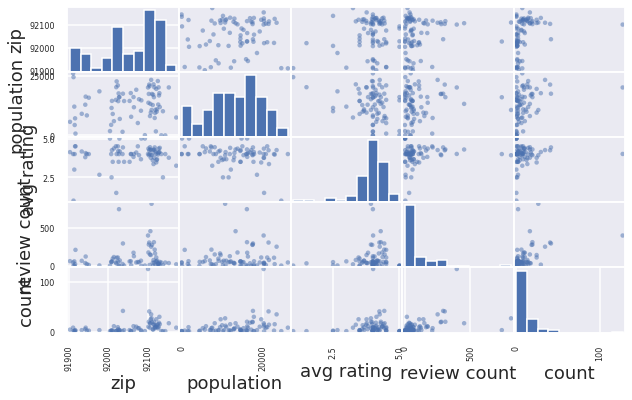

In [21]:
fig = pd.plotting.scatter_matrix(merged_df, figsize=(10,6))

In [22]:
dlow = pd.Series(merged_df.loc[merged_df['income class'] == 'low']['avg rating'], name="ratings")
dmid = pd.Series(merged_df.loc[merged_df['income class'] == 'mid']['avg rating'], name="ratings")
dhigh = pd.Series(merged_df.loc[merged_df['income class'] == 'high']['avg rating'], name="ratings")

Text(0.5, 1.0, 'High Income ZIP Codes')

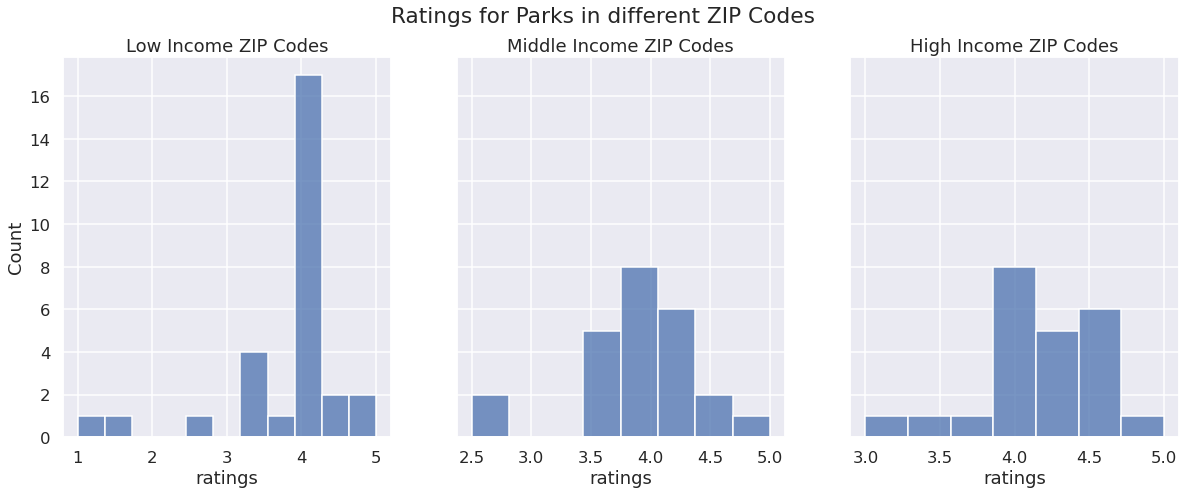

In [23]:
#histograms of low, mid, and high and respective ratings
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
fig.suptitle('Ratings for Parks in different ZIP Codes')

sns.histplot(data=dlow, ax=axes[0])
axes[0].set_title("Low Income ZIP Codes")

sns.histplot(data=dmid,ax=axes[1])
axes[1].set_title("Middle Income ZIP Codes")

sns.histplot(data=dhigh,ax=axes[2])
axes[2].set_title("High Income ZIP Codes")

The distribution of ratings for middle-income and high-income ZIP codes look incredibly similar, but there seems to be a big difference in the distributions of ratings for low-income ZIP codes. The range is larger and there’s many more ratings between 4 and 4.33.

To further investigate if there are any significant differences between the mean ratings of these neighborhoods, we will conduct simple t-tests for sample means.

In [24]:
#are distributions different for low and high income zip codes?
t_val, p_val = ttest_ind(np.mean(dlow),np.mean(dhigh))
if p_val < 0.05:
    print('There is a significant difference between mean ratings in low and high income ZIP codes!!')
else:
    print('There is NOT a significant difference between mean ratings in low and high income ZIP codes!!')

There is NOT a significant difference between mean ratings in low and high income ZIP codes!!


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
#are distributions different for low and middle income zip codes?
t_val, p_val = ttest_ind(np.mean(dlow),np.mean(dmid))
if p_val < 0.05:
    print('There is a significant difference between mean ratings in low and middle income ZIP codes!!')
else:
    print('There is NOT a significant difference between mean ratings in low and middle income ZIP codes!')

There is NOT a significant difference between mean ratings in low and middle income ZIP codes!


In [26]:
#are distributions different for middle and high income zip codes?
t_val, p_val = ttest_ind(np.mean(dmid),np.mean(dhigh))
if p_val < 0.05:
    print('There is a significant difference between mean ratings in high and middle income ZIP codes!!')
else:
    print('There is NOT a significant difference between mean ratings in high and middle income ZIP codes!!')

There is NOT a significant difference between mean ratings in high and middle income ZIP codes!!


After having performed a sample t-test for means for all three distributions, we determined that there's no significant difference between the means of parks for all three income levels. We fail to reject the null that the average ratings are roughly the same. This means that we can assume that the average ratings for parks located inlow-income, middle-income, and high-income zip codes are the same.

In [27]:
gdf = geopandas.read_file('san_diego_boundary_datasd.geojson')
parks = geopandas.read_file('data/parks_datasd.geojson')
sd = geopandas.read_file('Zip Codes.geojson')
sd = sd.rename({'zip':'Zip'},axis=1)
sd['Zip'] = sd['Zip'].astype(int)

(-117.67194082244546,
 -116.00511547166462,
 32.48571729914912,
 33.55393450763525)

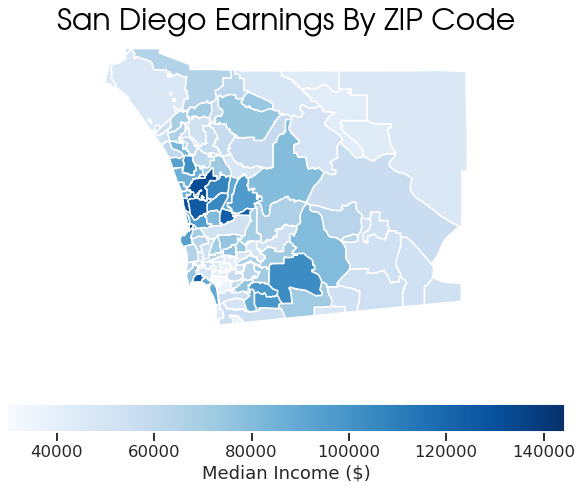

In [28]:
#compare this with a color-coded map of san diego based on median income
median_income_merge = median_incomes.merge(sd, how='left', on='Zip')
median_income_merge = GeoDataFrame(median_income_merge)

fig, ax = plt.subplots(figsize=(10,8))
plt.title('San Diego Earnings By ZIP Code', fontsize=30, fontname='URW Gothic', color='black') # 3
median_income_merge.plot(column='Median Income',
                        ax=ax,
                        legend=True,
                        cmap='Blues',
                        legend_kwds={'label': "Median Income (\\$)",
                                     'orientation': "horizontal"})
ax.axis('off')

After having mapped median income by ZIP code, we can see that people who earn above 100,000 in annual household income cluster near the middle of the coast. The people who live further inland and in the desert earn less on average.

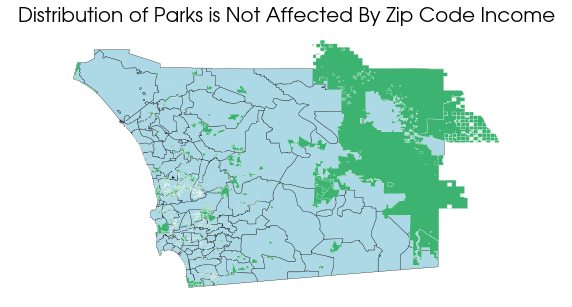

In [29]:
# Create visualizations of park locations in San Diego County
fig, ax = plt.subplots(figsize=(10,5))

sd.plot(ax=ax, color="lightblue", edgecolor='black', linewidth=0.3)
parks.plot(ax=ax, color = 'mediumseagreen', linewidth= 0.2)

plt.title('Distribution of Parks is Not Affected By Zip Code Income', fontsize=20, fontname='URW Gothic', color='black')
ax.axis('off')
plt.axis('equal')
plt.show()

Surprisingly, we see that the areas with the most number of parks and the largest parks are actually in the low-income desert area. However, this is just because this is where the Anza-Borrego Desert State Park, Cleveland National Park, and Borrego Springs are located. If we were to remove them, or just look at the number of parks per ZIP code, we would notice that there's actually many more parks clustered around high-income areas surrounding the coast.

(-117.58126283971525,
 -116.00943347084225,
 32.48571729914912,
 33.55393450763525)

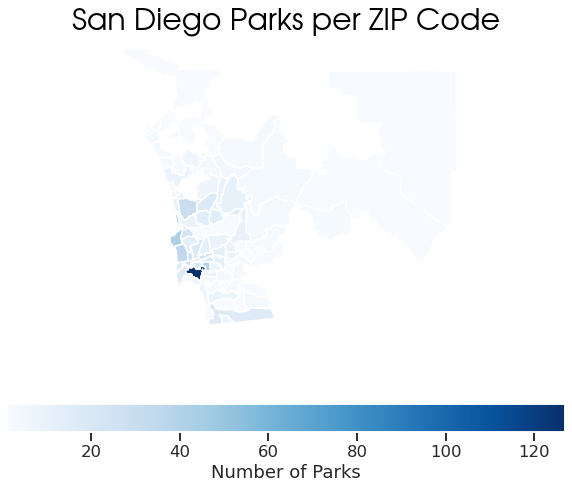

In [30]:
#compare this with a color-coded map of san diego based on number of parks
sd = sd.rename({'Zip':'zip'},axis=1)
geo_merge = merged_df.merge(sd, how='left', on='zip')
geo_merge = GeoDataFrame(geo_merge)

fig, ax = plt.subplots(figsize=(10,8))
plt.title('San Diego Parks per ZIP Code', fontsize=30, fontname='URW Gothic', color='black')
geo_merge.plot(column='count',
                ax=ax,
                legend=True,
                cmap='Blues',
                legend_kwds={'label': "Number of Parks",
                                'orientation': "horizontal"})
ax.axis('off')

# Ethics & Privacy

The SANDAG information is publicly available and the data is provided to us for the purpose of conducting research and projects. However, the Yelp reviewers did not explicitly provide us with informed consent, but they may have signed a Terms of Service Agreement with Yelp, which allows us to use their API and scrape reviews. Fortunately, the information is randomized and de-identified for both data sets.

The SANDAG data set does not have any privacy concerns because it’s information aggregated on the ZIP code level, which means all entries are de-identified and untraceable. For the Yelp dataset, it’s de-identified information, but it would is easily re-identifiable if I were to use the text reviews to search for the original entries, since each review  is linked to a park and it’s relatively unlikely for there to be reviews that are worded exactly the same on Yelp. Since Yelps are usually tied to a user profile, and Yelp encourages individuals to post using their real information rather than pseudonyms, there are many privacy concerns this can present to users who use Yelp, especially since individuals are more likely to post reviews in places they have been to, and this can indicate a pattern of activity such as whether or not the user lives near these parks. For a prominent example of a Yelp reviewer facing consequences from posting identifiable information, there has been at least one instance of a Yale Dean losing her job because of language used in a negative Yelp review. In order to comply with data privacy requirements, I decided to not use the text reviews, and I removed the park names and addresses from my dataset to prevent biasing my conclusion. 

Census data is collected for the purposes of analysis, and we know that it’s representative of the population. It’s extremely robust, as every ZIP code is represented, it uses standardized information for income, and the information is all deidentified and not re-identifiable.
Yelp is not a representative data set, as its user base skews young, affluent, tech-savvy, English-speaking, and college-educated.  In order to reduce confounding variables, we could compare our results and repeat this analysis with another dataset preview the dataset before it’s de-identified . Yelp is also meant to be used as a consumer tool and advertising platform, so it’s not as complete of a dataset and the information may not be as robust as census-level data. The primary use case of Yelp as being an aggregator website for restaurant reviews means that our secondary use of this information contains many confounding variables and selection biases that could be addressed by running a prospective study rather than using retrospective data

As Yelp user reviews tend to show an over-representation of reviews from its user base, which is comprised of individuals who are more likely to be college-educated (61%), wealthy (53%), and young (67% are ages 18-54) than the general population, relying solely on this preliminary analysis has the potential to worsen equity across socioeconomic areas as it draws upon a non-representative sample of study participants. Based on my analysis, wealthier areas tend to have more parks and  I would also hypothesize that wealthier individuals would be able to have more free time to visit parks and leave feedback in the form of Yelp reviews, which is mediated through access to technology such as a smartphone to access to Yelp app or the Yelp website. I would additionally hypothesize that individuals who are lower income, lower in educational attainment, and much younger (ages 0-17) or much older (ages 70+) would be less likely to be represented in my sample, so additional measures should be taken to be inclusive of all members of the community. 

Reference: https://www.yelp-press.com/company/fast-facts/default.aspx 

Many studies have measured self-selection bias as well as variations in technology use. A well-designed prospective research study to test my hypothesis should have additional measures to control for data privacy (such as creating an anonymous Google Form that is available online as well as in-print) as well as the ability to capture more comprehensive demographic information to control for confounding variables. Since the demographic group that is being studied has a high proportion of individuals who live in Southern California, it may be useful to make the study materials available in multiple languages, such as Spanish. 

Other research papers have dealt with the issue of selection bias by enrolling multiple individuals based in different geographical regions, such as Atlanta, New York, Los Angeles, and Washington, DC. This has the effect of creating more diverse datasets and allows us to see if the study results would be generalizable to different areas of the country. In clinical research in order to control for confounding at one site, scientists will use multi-site trials to see if the same results are shown in multiple settings.

# Conclusion & Discussion

In this project, I sought to explore the relationship between "neighborhood" income and the distribution of parks as well as park ratings. After cleaning the Yelp and SANDAG datasets and creating a few exploratory data visualizations, I was able to conclude that although there is a significant difference between the number of parks in high and low income neighborhoods, with richer ZIP codes having many more parks, there’s not a significant difference between their average ratings. I encountered limitations in terms of how simple my analysis was in evaluating the relationship between average ratings and zip codes, as a simple t-test might not have been enough, and I may have overlooked an underlying cause or confounder. Much of my analysis also came from my visualizations, which may be susceptible to the same or similar confounders.

This project may help to provide further insight on the relationship between income inequality and a community's health, where the wealthy have much more access to parks and recreation centers. It also has the potential to inform future decisions on where to build more park infrastructure and to help communicate the importance of physical activity.